In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
sns.set_style('whitegrid')

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%config InlineBackend.figure_format = 'retina'

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPClassifier

In [2]:
breast_cancer = pd.read_table('BreastDiagnostic.txt', sep = ',', header = None)

In [3]:
display(HTML(
    f"Number of attributes: {breast_cancer.shape[1] - 2} <br/>"
    f"Number of patients: {breast_cancer.shape[0]} <br/>"))

In [4]:
y = breast_cancer.loc[:,1]
X = breast_cancer.drop(columns = 1)
y = y.values
y[y=='M'] = 1
y[y=='B'] = 0
y = y.astype(int)

In [5]:
from sklearn.preprocessing import minmax_scale, OrdinalEncoder

X = pd.DataFrame(minmax_scale(X))
enc = OrdinalEncoder()
breast_cancer.loc[:,1] = enc.fit_transform(breast_cancer.loc[:,1].to_numpy().reshape(-1,1))

## 1) Model training using Sklearn

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [7]:
# Define the model & learning using scikit-learn
mdl = MLPClassifier(solver = 'lbfgs', alpha=1e-7, hidden_layer_sizes=(10, 5))
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)

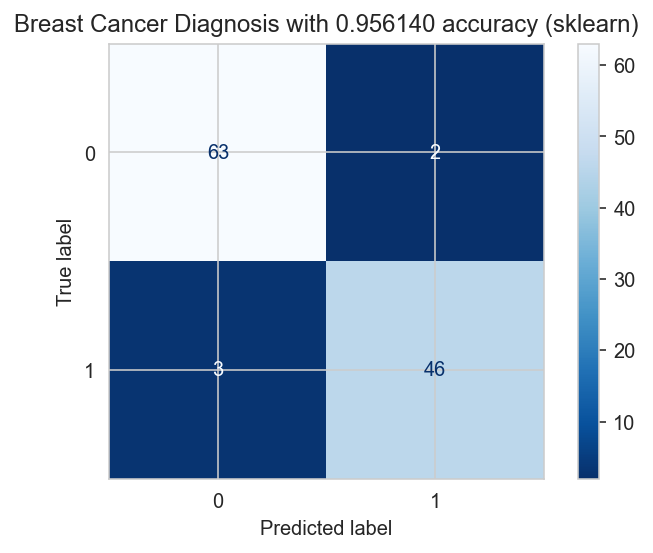

In [8]:
from sklearn.metrics import plot_confusion_matrix

display(HTML(
    f"sklearn model's score: {mdl.score(X_test, y_test)} <br/>"
))

plot_confusion_matrix(mdl, X_test, y_test, cmap = 'Blues_r')
plt.title('Breast Cancer Diagnosis with %f accuracy (sklearn)' %mdl.score(X_test, y_test));

## 2) Model building & training with Keras

In [9]:
from keras.utils import to_categorical

batch_size, epochs = 30, 15 
y_train1, y_test1 = to_categorical(y_train), to_categorical(y_test)

In [10]:
# Define the model & learning using scikit-learn

model = Sequential()
model.add(Dense(64, activation='relu', input_dim = 31)) 
model.add(Dense(64, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax')) 

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train1, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Epoch 1/15
14/14 [==============================] - 0s 11ms/step - loss: 0.6667 - accuracy: 0.6284 - val_loss: 0.6260 - val_accuracy: 0.7609
Epoch 2/15
14/14 [==============================] - 0s 2ms/step - loss: 0.5624 - accuracy: 0.8557 - val_loss: 0.4821 - val_accuracy: 0.8696
Epoch 3/15
14/14 [==============================] - 0s 2ms/step - loss: 0.4153 - accuracy: 0.8778 - val_loss: 0.2889 - val_accuracy: 0.9565
Epoch 4/15
14/14 [==============================] - 0s 2ms/step - loss: 0.2856 - accuracy: 0.8924 - val_loss: 0.1772 - val_accuracy: 0.9565
Epoch 5/15
14/14 [==============================] - 0s 2ms/step - loss: 0.2207 - accuracy: 0.9120 - val_loss: 0.1375 - val_accuracy: 0.9783
Epoch 6/15
14/14 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.9291 - val_loss: 0.1161 - val_accuracy: 0.9783
Epoch 7/15
14/14 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.9462 - val_loss: 0.0705 - val_accuracy: 1.0000
Epoch 8/15
14/14 [=

In [11]:
score = model.evaluate(X_test, y_test1, batch_size=batch_size, verbose=1)

4/4 [==============================] - 0s 731us/step - loss: 0.0761 - accuracy: 0.9737


## 3) 10-fold cross-validation

In [12]:
# Sklearn cv scores
from sklearn.model_selection import cross_val_score, KFold

cv = cross_val_score(mdl, X_train, y_train, cv = 10)

In [13]:
display(HTML(
    f"sklearn cv scores: {cv} <br/>"
    f"Average score: {np.mean(cv)} <br/>"
))

In [14]:
# Keras cv scores

cv = 10
k_fold = KFold(n_splits = cv, random_state = 41, shuffle = True)
lis_X, lis_y = [X], [y]
epoch = 15

avg_score = []
for X, y in zip(lis_X, lis_y):
    
    score_kf = []
    for train_idx, test_idx in k_fold.split(X):
        X_train, X_test = X.loc[train_idx,:], X.loc[test_idx,:]
        y_train, y_test = y[train_idx], y[test_idx]
        y_train1, y_test1 = to_categorical(y_train), to_categorical(y_test)
        
        # Model building
        model = Sequential()
        model.add(Dense(64, activation='relu', input_dim = 31)) 
        model.add(Dense(64, activation='relu')) 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(2, activation='softmax')) 

        model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

        # Model training
        history = model.fit(X_train, y_train1, batch_size=batch_size, epochs=epoch, 
                            verbose=0, validation_split=0.1)
        
        # Model evaluation
        score_kf.append(model.evaluate(X_test, y_test1, batch_size=batch_size, verbose=0)[1])
        
    score_kf = np.array(score_kf)
    avg_score.append(np.mean(score_kf))

In [15]:
display(HTML(
    f"Keras cv scores: {score_kf} <br/>"
    f"Average score: {avg_score[0]} <br/>"
))

## 4) Heterogeneous data sets

In [16]:
data_host = pd.read_table('SPLEX_host.txt', sep = ' ')
data_env = pd.read_table('SPLEX_env.txt', sep = ' ')
data_mic = pd.read_table('SPLEX_micro.txt', sep = ' ')
data_comb = pd.concat((data_host, data_env, data_mic), axis = 1)
y = data_mic.Gene_count
data_comb.drop(columns = ['Gene_count'], inplace = True)

In [17]:
sk_host = MLPClassifier(solver = 'adam', alpha=1e-7, hidden_layer_sizes=(30, 30))
sk_env = MLPClassifier(solver = 'adam', alpha=1e-7, hidden_layer_sizes=(30, 30))
sk_mic = MLPClassifier(solver = 'adam', alpha=1e-7, hidden_layer_sizes=(30, 30))
sk_comb = MLPClassifier(solver = 'adam', alpha=1e-7, hidden_layer_sizes=(30, 30))

In [18]:
cv_host = cross_val_score(sk_host, X_train, y_train, cv = 10);
cv_env = cross_val_score(sk_env, X_train, y_train, cv = 10);
cv_mic = cross_val_score(sk_mic, X_train, y_train, cv = 10);
cv_comb = cross_val_score(sk_comb, X_train, y_train, cv = 10);

/Users/bedisjaouani/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/bedisjaouani/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/bedisjaouani/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/bedisjaouani/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

/Users/bedisjaouani/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/bedisjaouani/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/bedisjaouani/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/bedisjaouani/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

In [19]:
display(HTML(
    f"Sklearn cv scores:<br/>"
    f"Host: {np.mean(cv_host)} <br/>"
    f"Environment: {np.mean(cv_env)} <br/>"
    f"Microbiota: {np.mean(cv_mic)} <br/>"
    f"Combined: {np.mean(cv_comb)} <br/>"
))

In [20]:
# Keras cv scores
from sklearn.preprocessing import LabelEncoder, StandardScaler

cv = 10
k_fold = KFold(n_splits = cv, random_state = 41, shuffle = True)
scaler = StandardScaler()
lis_X, lis_y = [scaler.fit_transform(data_host), 
                scaler.fit_transform(data_env), 
                scaler.fit_transform(data_mic), 
                scaler.fit_transform(data_comb)], [y, y, y, y]
epoch, batch_size = 20, 15


avg_score = []
for X, y in zip(lis_X, lis_y):
    inp_dim = X.shape[1]
    score_kf = []
    for train_idx, test_idx in k_fold.split(X):
        X_train, X_test = X[train_idx,:], X[test_idx,:]
        y_train, y_test = y[train_idx], y[test_idx]
        #y_train1, y_test1 = to_categorical(y_train)[:,1:], to_categorical(y_test)[:,1:]
        # encode class values as integers
        enc1, enc2 = LabelEncoder(), LabelEncoder()
        enc1.fit(y_train)
        y_train1 = enc1.transform(y_train)
        enc2.fit(y_test)
        y_test1 = enc2.transform(y_test)
        
        # Model building
        model = Sequential()
        model.add(Dense(30, activation='relu', input_dim = inp_dim)) 
        model.add(Dense(30, activation='relu')) 
        #model.add(Dense(30, activation='relu'))
        model.add(Dense(1, activation='sigmoid')) 

        model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

        # Model training
        history = model.fit(X_train, y_train1, batch_size=batch_size, epochs=epoch, 
                            verbose=0, validation_split=0.1)
        
        # Model evaluation
        score_kf.append(model.evaluate(X_test, y_test1, batch_size=batch_size, verbose=0)[1])
        
    score_kf = np.array(score_kf)
    avg_score.append(np.mean(score_kf))

In [21]:
display(HTML(
    f"Keras cv scores:<br/>"
    f"Host: {avg_score[0]} <br/>"
    f"Environment: {avg_score[1]} <br/>"
    f"Microbiota: {avg_score[2]} <br/>"
    f"Combined: {avg_score[3]} <br/>"
))